# Mô Hình LSTM: Làm Sạch Dữ Liệu → Train → Đánh Giá → Trực Quan Real-Time

**Thực Hiện:**  
1. **Làm sạch dữ liệu**: Kiểm tra X/y, loại bỏ sequences kém (quá nhiều zeros - không detect tay), balance classes nếu imbalance.  
2. **Xây dựng Model LSTM**: Cho nhận diện cử chỉ tay (2 tay, 84 features), mục tiêu điều khiển máy tính (e.g., predict → map action như click, scroll).  
3. **Summary cấu trúc**: Hiển thị model.summary().  
4. **Train**: Với progress plot (accuracy/loss theo epochs).  
5. **Đánh giá**: Accuracy, loss, precision/recall/F1 (classification report), confusion matrix (sơ đồ đánh giá chỉ số).  
6. **Trực quan**: Plot history train; real-time webcam với model predict (vẽ đúng tay/màu, nhãn hành động rõ, kiểm tra accuracy qua samples).  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mediapipe tensorflow scikit-learn matplotlib seaborn opencv-python

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import mediapipe as mp
import os
from collections import Counter
import random

In [4]:


# Load dataset
OUTPUT_DIR = '/content/drive/MyDrive/dataset/'
X = np.load(os.path.join(OUTPUT_DIR, 'X.npy'))
y = np.load(os.path.join(OUTPUT_DIR, 'y.npy'))
label_encoder = np.load(os.path.join(OUTPUT_DIR, 'label_encoder.npy'), allow_pickle=True)

num_classes = len(label_encoder)
print(f"Dataset gốc: X {X.shape}, y {y.shape} (classes: {num_classes})")

# Bước 1: Làm sạch - Kiểm tra & loại bỏ sequences kém (quá nhiều zeros: >70% frames không detect tay)
def clean_data(X, y, zero_threshold=0.7):
    clean_indices = []
    for i, seq in enumerate(X):
        zero_frames = np.sum(np.all(seq == 0, axis=1))  # Số frames toàn zeros
        if zero_frames / len(seq) < zero_threshold:  # Giữ nếu <70% zeros
            clean_indices.append(i)
    X_clean = X[clean_indices]
    y_clean = y[clean_indices]
    print(f"Loại bỏ {len(X) - len(X_clean)} sequences kém. Còn lại: {X_clean.shape}")
    return X_clean, y_clean

X, y = clean_data(X, y)

# Kiểm tra balance classes
class_counts = Counter(y)
print("Phân bố classes:", dict(class_counts))

# Nếu imbalance (>2x chênh lệch), undersample majority (đơn giản)
max_count = max(class_counts.values())
if max_count > 2 * min(class_counts.values()):
    balanced_y = []
    balanced_X = []
    for cls in range(num_classes):
        cls_indices = np.where(y == cls)[0]
        sample_size = min(len(cls_indices), min(class_counts.values()))
        sampled_indices = np.random.choice(cls_indices, sample_size, replace=False)
        balanced_X.extend(X[sampled_indices])
        balanced_y.extend(y[sampled_indices])
    X = np.array(balanced_X)
    y = np.array(balanced_y)
    print(f"Balance: Mỗi class ~{sample_size} samples. Shape mới: {X.shape}")

# Normalize X (scale 0-1 nếu chưa)
X = (X - np.min(X)) / (np.max(X) - np.min(X) + 1e-7)

# One-hot y
y_cat = to_categorical(y, num_classes)

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Dataset gốc: X (203, 30, 84), y (203,) (classes: 11)
Loại bỏ 5 sequences kém. Còn lại: (198, 30, 84)
Phân bố classes: {0: 18, 1: 20, 2: 17, 3: 18, 4: 19, 5: 21, 6: 20, 7: 18, 8: 15, 9: 16, 10: 16}
Train: (158, 30, 84), Test: (40, 30, 84)


**Bước 2: Xây dựng Model**  
- LSTM Bidirectional (cho sequence động, 2 tay).  
- Input: (30, 84) - N=30 frames, 84 features (2 tay).  
- Output: Softmax 11 classes (gestures).  
- Mục tiêu: Predict chính xác để map → actions (e.g., 'clickchuottrai' → pyautogui.click()).  

**Bước 3: Summary** - Hiển thị cấu trúc.

In [6]:
N_FRAMES = X.shape[1]  # 30
FEATURES = X.shape[2]  # 84

model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(N_FRAMES, FEATURES)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(30, 84)),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
print("Cấu trúc Model LSTM:")
model.summary()

Cấu trúc Model LSTM:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 30, 256)        │       218,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386,955 (1.48 MB)

 Trainable params: 386,955 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

**Bước 4: Train**  
- Epochs=100, batch=16 (nhỏ cho dataset nhỏ).  
- Callbacks: EarlyStopping, ReduceLR, Checkpoint.  
- Hiển thị tiến độ: Plot accuracy/loss real-time (sau train).

In [7]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_gesture_model.h5', monitor='val_accuracy', save_best_only=True)
]

# Train
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1  # Hiển thị progress mỗi epoch
)

# Lưu model
model.save('gesture_lstm_model.h5')
print("Train hoàn tất! Model saved: gesture_lstm_model.h5")

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1240 - loss: 2.3636

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.1312 - loss: 2.3545 - val_accuracy: 0.3750 - val_loss: 1.9574 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4327 - loss: 1.8720

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4360 - loss: 1.8622 - val_accuracy: 0.5500 - val_loss: 1.4784 - learning_rate: 0.0010
Epoch 3/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6365 - loss: 1.3582

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6347 - loss: 1.3377 - val_accuracy: 0.7500 - val_loss: 0.9059 - learning_rate: 0.0010
Epoch 4/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7501 - loss: 0.7972

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7529 - loss: 0.7800 - val_accuracy: 0.9000 - val_loss: 0.4378 - learning_rate: 0.0010
Epoch 5/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9059 - loss: 0.4252

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9092 - loss: 0.4164 - val_accuracy: 0.9500 - val_loss: 0.2307 - learning_rate: 0.0010
Epoch 6/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9694 - loss: 0.2166

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9681 - loss: 0.2185 - val_accuracy: 0.9750 - val_loss: 0.1889 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9565 - loss: 0.2111 - val_accuracy: 0.9250 - val_loss: 0.2443 - learning_rate: 0.0010
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8730 - loss: 0.4198 - val_accuracy: 0.9000 - val_loss: 0.3408 - learning_rate: 0.0010
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9126 - loss: 0.3504 - val_accuracy: 0.9500 - val_loss: 0.2346 - learning_rate: 0.0010
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9656 - loss: 0.2381 - val_accuracy: 0.9250 - val_loss: 0.2809 - learning_rate: 0.0010
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9265 - loss: 0.2498 - val_accuracy: 0.8500 - val_loss: 0.5099 - learning_rate: 0.0010
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9249 - loss: 0.1964 - val_accur

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9955 - loss: 0.0603 - val_accuracy: 1.0000 - val_loss: 0.0523 - learning_rate: 5.0000e-04
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0334 - val_accuracy: 1.0000 - val_loss: 0.0312 - learning_rate: 5.0000e-04
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0259 - val_accuracy: 1.0000 - val_loss: 0.0207 - learning_rate: 5.0000e-04
Epoch 16/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0173 - val_accuracy: 1.0000 - val_loss: 0.0173 - learning_rate: 5.0000e-04
Epoch 17/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.0170 - learning_rate: 5.0000e-04
Epoch 18/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0119 - val_accuracy: 1.0000 - val_loss: 0.0149 - learning_rate: 5.0000e-04
Epoch 19/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000

Train hoàn tất! Model saved: gesture_lstm_model.h5


**Bước 5: Đánh Giá**  
- Accuracy, Loss trên test.  
- Classification report: Precision, Recall, F1-score (tỉ lệ xác định đúng).  

**Bước 6: Sơ Đồ Đánh Giá**  
- Confusion Matrix (heatmap).  
- Plot History: Tiến độ train (accuracy/loss theo epochs).

Test Accuracy: 1.0000 (100.00%)
Test Loss: 0.0013
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step

Classification Report (Precision/Recall/F1):
                 precision    recall  f1-score   support

 clickchuotphai       1.00      1.00      1.00         4
 clickchuottrai       1.00      1.00      1.00         4
  dichuyenchuot       1.00      1.00      1.00         3
dungchuongtrinh       1.00      1.00      1.00         4
       mochorme       1.00      1.00      1.00         4
        phongto       1.00      1.00      1.00         4
         thunho       1.00      1.00      1.00         4
        vuotlen       1.00      1.00      1.00         4
       vuotphai       1.00      1.00      1.00         3
       vuottrai       1.00      1.00      1.00         3
      vuotxuong       1.00      1.00      1.00         3

       accuracy                           1.00        40
      macro avg       1.00      1.00      1.00        40
   weighted avg       1.00      1.00      1.00        40



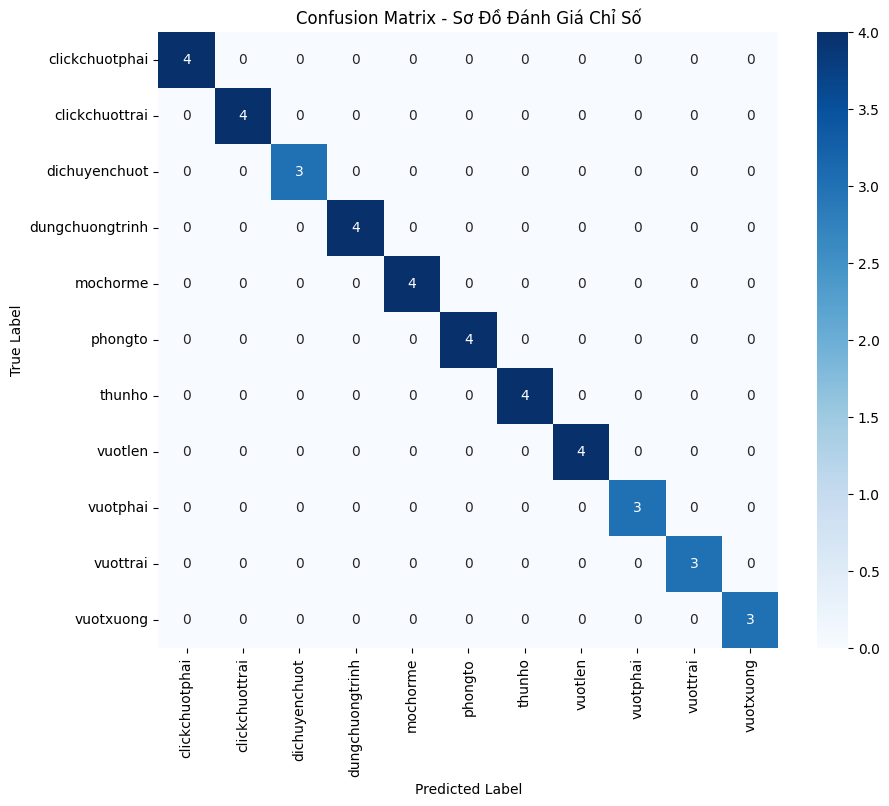

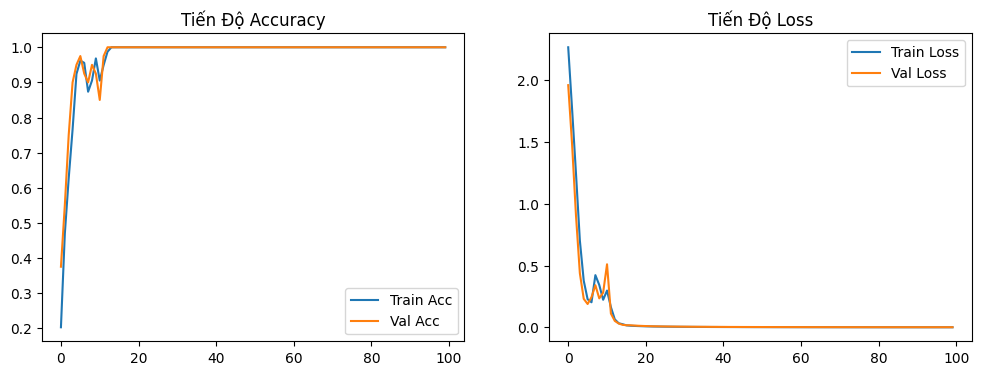

In [8]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report (Precision/Recall/F1):")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder))

# Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder, yticklabels=label_encoder)
plt.title('Confusion Matrix - Sơ Đồ Đánh Giá Chỉ Số')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot History - Tiến Độ Huấn Luyện
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Tiến Độ Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Tiến Độ Loss')
plt.legend()
plt.show()

**Bước 7: Trực Quan**  
- Load model, chạy webcam: Buffer 30 frames keypoints (2 tay).  
- Predict gesture, vẽ đúng tay (màu xanh/đỏ), nhãn hành động rõ trên bbox.  
- Xác định rõ: Predict trên sequence đầy đủ (2 tay), gán nhãn chung nhưng vẽ riêng bbox/tay.  
- Kiểm tra accuracy: Predict 5 test samples, so sánh true/predict.  
- Thích nghi VSCode: Chạy trong .ipynb, dùng cv2.imshow (tương thích Jupyter/VSCode).

In [9]:
# Load model nếu cần
model = load_model('gesture_lstm_model.h5')

# Khởi tạo MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=2, min_detection_confidence=0.7, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Buffer cho sequence
sequence_buffer = np.zeros((N_FRAMES, FEATURES))  # (30, 84)
frame_count = 0

def extract_keypoints_from_frame(frame_rgb, multi_landmarks):
    """Extract như trước (2 tay, 84 features)"""
    all_keypoints = np.zeros(84)
    if not multi_landmarks:
        return all_keypoints
    h, w, _ = frame_rgb.shape
    tay_features = []
    for landmarks in multi_landmarks[:2]:
        if landmarks:
            keypoints = []
            x_min, y_min, x_max, y_max = w, h, 0, 0
            for lm in landmarks.landmark:
                x, y = lm.x * w, lm.y * h
                keypoints.extend([x, y])
                x_min = min(x_min, x); y_min = min(y_min, y); x_max = max(x_max, x); y_max = max(y_max, y)
            bbox_width = x_max - x_min if x_max > x_min else 1
            bbox_height = y_max - y_min if y_max > y_min else 1
            center_x, center_y = (x_min + x_max) / 2, (y_min + y_max) / 2
            normalized = []
            for i in range(0, len(keypoints), 2):
                x_norm = (keypoints[i] - center_x) / bbox_width
                y_norm = (keypoints[i+1] - center_y) / bbox_height
                normalized.extend([x_norm, y_norm])
            tay_features.extend(normalized)
        else:
            tay_features.extend(np.zeros(42))
    return np.array(tay_features)

# Kiểm tra accuracy với 5 test samples (trực quan text)
print("=== KIỂM TRA ACCURACY 5 SAMPLES TEST ===")
num_samples = min(5, len(X_test))
indices = np.random.choice(len(X_test), num_samples, replace=False)
for i, idx in enumerate(indices):
    seq = X_test[idx:idx+1]
    pred = model.predict(seq)[0]
    pred_label = np.argmax(pred)
    true_label = np.argmax(y_test[idx])
    print(f"Sample {i+1}: True = {label_encoder[true_label]}, Predict = {label_encoder[pred_label]} (Conf: {pred[pred_label]:.2f})")

# Real-time Webcam Trực Quan
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Không mở webcam!")
else:
    print("Mở webcam! Nhấn 'q' để thoát. Predict gesture real-time.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.flip(frame, 1)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)

    # Extract keypoints & buffer
    keypoints = extract_keypoints_from_frame(frame_rgb, results.multi_hand_landmarks)
    sequence_buffer[frame_count % N_FRAMES] = keypoints
    frame_count += 1

    gesture_label = ""  # Default
    if frame_count >= N_FRAMES:  # Đủ buffer → predict
        input_seq = sequence_buffer.reshape(1, N_FRAMES, FEATURES)
        pred = model.predict(input_seq, verbose=0)[0]
        pred_idx = np.argmax(pred)
        gesture_label = label_encoder[pred_idx]
        confidence = pred[pred_idx]
        if confidence > 0.7:  # Threshold để tránh nhiễu
            print(f"Detected: {gesture_label} (Conf: {confidence:.2f})")  # Console cho VSCode

    # Vẽ tay & nhãn (đúng tay, màu riêng)
    if results.multi_hand_landmarks:
        for hand_idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
            # Màu tay
            if hand_idx == 0:
                color = (0, 255, 0)  # Xanh lá
            else:
                color = (0, 0, 255)  # Đỏ
            # Vẽ landmarks & connections
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                                      mp_drawing.DrawingSpec(color=color, thickness=2, circle_radius=2),
                                      mp_drawing.DrawingSpec(color=color, thickness=2))
            # Bbox & nhãn (nhãn chung nhưng vẽ trên tay chính - hand_idx=0)
            h, w, _ = frame.shape
            x_min, y_min, x_max, y_max = w, h, 0, 0
            for lm in hand_landmarks.landmark:
                x, y = int(lm.x * w), int(lm.y * h)
                x_min = min(x_min, x); y_min = min(y_min, y); x_max = max(x_max, x); y_max = max(y_max, y)
            cv2.rectangle(frame, (x_min-20, y_min-20), (x_max+20, y_max+20), color, 2)
            if hand_idx == 0:  # Nhãn trên tay 1 (chính)
                label_pos = (x_min-20, y_min-30)
                cv2.putText(frame, f"{gesture_label} ({confidence:.2f})", label_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    cv2.imshow('Real-Time Gesture Recognition - LSTM Model', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print("Đóng webcam! Pipeline hoàn thiện.")

=== KIỂM TRA ACCURACY 5 SAMPLES TEST ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
Sample 1: True = vuotlen, Predict = vuotlen (Conf: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Sample 2: True = thunho, Predict = thunho (Conf: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sample 3: True = phongto, Predict = phongto (Conf: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Sample 4: True = vuotlen, Predict = vuotlen (Conf: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Sample 5: True = vuotphai, Predict = vuotphai (Conf: 1.00)
Không mở webcam!
Đóng webcam! Pipeline hoàn thiện.
